In [1]:
import numpy as np
import pandas as pd
import math
import random

from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

import pandas_profiling
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

data = pd.read_csv("data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14726 entries, 0 to 14725
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Unnamed: 0       14726 non-null  int64
 1   is_test          14726 non-null  bool 
 2   user_level       14726 non-null  int64
 3   agegroup         14726 non-null  int64
 4   gender           14726 non-null  int64
 5   publisherid      14726 non-null  int64
 6   deviceplatform   14726 non-null  int64
 7   hourofdaybucket  14726 non-null  int64
 8   dayofweekbucket  14726 non-null  int64
dtypes: bool(1), int64(8)
memory usage: 934.9 KB


In [4]:
training_data = data[~data.is_test]

In [5]:
test_data = data[data.is_test]

In [6]:
training_data.head()

,Unnamed: 0,is_test,user_level,agegroup,gender,publisherid,deviceplatform,hourofdaybucket,dayofweekbucket
0,0,False,1,0,2,2552816994824234651,1,4,0
1,1,False,1,6,1,367,1,1,1
2,2,False,1,3,2,2614530555266775655,2,4,2
3,3,False,1,3,2,2614530555266775655,2,2,1
4,4,False,1,3,2,2614530555266775655,2,4,1


In [7]:
test_data.head()

,Unnamed: 0,is_test,user_level,agegroup,gender,publisherid,deviceplatform,hourofdaybucket,dayofweekbucket
5,5,True,1,0,1,284,1,3,0
8,8,True,1,5,1,243,1,5,1
11,11,True,1,5,1,299,1,4,2
35,35,True,1,0,1,299,1,0,1
40,40,True,1,5,2,157,1,4,1


In [8]:
def feature_encoder(training_data: List, test_data: List, encoding_features: List, is_data_frame=False):
    if not is_data_frame:
        training_data = pd.DataFrame(dict(record) for record in training_data)
        test_data = pd.DataFrame(dict(record) for record in test_data)

    feature_mappings = {}
    for c in encoding_features:
        temp = training_data[c].astype('category').cat
        # by default, the missing value is encoded as -1. In our case, missing value should be encoded as 0
        training_data[c] = temp.codes + 1
        feature_mappings[c] = {cat: n for n, cat in enumerate(temp.categories, start=1)}

    for c in encoding_features:
        test_data[c] = test_data[c].apply(lambda x: feature_mappings[c].get(x, 0))
    return training_data, test_data, feature_mappings

In [8]:
LOOKALIKE_TARGETING_BASE_VARIABLES = [
    'agegroup',
    'gender',
    'publisherid',
    'deviceplatform',
    'hourofdaybucket',
    'dayofweekbucket'
]
LOOKALIKE_TARGETING_ENCODING_FEATURES = LOOKALIKE_TARGETING_BASE_VARIABLES

In [27]:
training_data.shape

(13627, 9)

In [28]:
test_data.shape

(1099, 9)

In [13]:
for record in training_data:
    print(record)

Unnamed: 0
is_test
user_level
agegroup
gender
publisherid
deviceplatform
hourofdaybucket
dayofweekbucket


In [10]:
training_data_df, test_data_df, feature_mappings = feature_encoder(training_data, test_data, LOOKALIKE_TARGETING_ENCODING_FEATURES, True)

<ipython-input-8-448c565e32cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[c] = temp.codes + 1


In [11]:
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13627 entries, 0 to 14725
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Unnamed: 0       13627 non-null  int64
 1   is_test          13627 non-null  bool 
 2   user_level       13627 non-null  int64
 3   agegroup         13627 non-null  int8 
 4   gender           13627 non-null  int8 
 5   publisherid      13627 non-null  int16
 6   deviceplatform   13627 non-null  int8 
 7   hourofdaybucket  13627 non-null  int8 
 8   dayofweekbucket  13627 non-null  int8 
dtypes: bool(1), int16(1), int64(2), int8(5)
memory usage: 425.8 KB


### Binary classifier

In [31]:
X_train = training_data[LOOKALIKE_TARGETING_BASE_VARIABLES]
y_train = training_data['user_level']

X_test = test_data[LOOKALIKE_TARGETING_BASE_VARIABLES]
y_test = test_data['user_level']

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=28)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=28)

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.68523002, 0.71047996, 0.69594892])

In [47]:
sum(y_train)

3827

In [48]:
sum(y_train_pred)

1279

In [41]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

[[9011  789]
 [3337  490]]


In [50]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train, y_train_pred)
print(precision)
print(cm[1, 1] / (cm[0, 1] + cm[1, 1]))

0.3831118060985145
0.3831118060985145


In [53]:
recall = recall_score(y_train, y_train_pred)
print(recall)
print(cm[1, 1] / (cm[1, 0] + cm[1, 1]))

0.1280376273843742
0.1280376273843742


In [54]:
from sklearn.metrics import f1_score

print(f1_score(y_train, y_train_pred))
print(2 * (precision * recall) / (precision + recall))
print(cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2))

0.1919310614962789
0.1919310614962789
0.1919310614962789


In [56]:
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

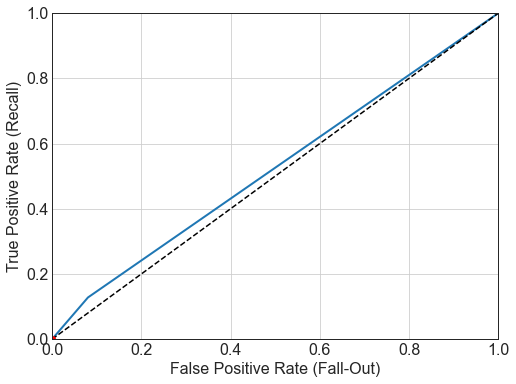

In [62]:
from sklearn.metrics import precision_recall_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
# threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [64]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

0.5237637116513707